# RU-WRF 4.1: Create profile plots of wind speed

_Written by Lori Garzio, June 11, 2020_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook demonstrates how to access native model level data from the Rutgers University Weather Research and Forecasting Model (RU-WRF 4.1) from the [RUWRF THREDDs server](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html), subset the data for a specific day and location, grab the u and v components of wind speed at all model level heights, calculate windspeed from u and v, create profiles of wind speed for a 24-hour period, and save the plots to your local machine.

_**WARNING**: the model output is very large and these plots take several minutes to generate. Please restrict your request to one day to avoid crashing the THREDDs server._

In [1]:
# import the required packages for data access and plotting
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Data Access

The RU-WRF 4.1 THREDDs server can be accessed [here](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html). For this example, we will be using the [Best](http://tds.marine.rutgers.edu/thredds/catalog/cool/ruwrf/wrf_4_1_3km_native_levels/catalog.html?dataset=cool/ruwrf/wrf_4_1_3km_native_levels/WRF_4.1_3km_Native_Levels_Dataset_Best) dataset from the WRF 4.1 3km Native Levels Dataset.

Once you've located the Best dataset and reviewed the documentation, you can access the data using Python via the Data URL found in the OPENDAP link. You will also need to specify: 

* the path to the local directory to which you want to save the plots
* the location (defined by latitude and longitude coordinates) at which you want to plot wind speeds
* the date you want to plot

_Some important information from the metadata page in the THREDDs server about time and geospatial coverage for this dataset:_

**Geospatial Coverage:**
* Longitude: -80.45 to -68.55 degrees_east
* Latitude: 34.32 to 43.15 degrees_north

**Start Time:** 2020-06-09T00:00:00Z

For this example, we will be pulling model data from the closest latitude/longitude coordinate point to the New York State Energy Research and Development Authority (NYSERDA) North LiDAR buoy, which is located off the coast of New Jersey. 

The map below shows the NYSERDA North buoy (red circle) located within a potential wind energy development area (blue areas). Also pinned in this image are the NYSERDA South LiDAR buoy and several National Data Buoy Center (NDBC) buoys. The white areas are the current wind energy lease areas. Image created by Jaden Dicopoulos.

![NYSERDA_buoys](../imgs/NYSERDA_Buoy_Locations.png)
<!-- <img src="../img/NYSERDA_Buoy_Locations2.png" -->

In [2]:
# data url
wrf_file = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_native_levels/WRF_4.1_3km_Native_Levels_Dataset_Best'

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/rucool/tutorials'

# NYSERDA North buoy location 
loc = dict(lon=-72.7173, lat=39.9686)

# date to plot
plt_date = dt.datetime(2020, 6, 10)

Next, we'll use [xarray](https://pypi.org/project/xarray/) to open and subset the RU-WRF data file based on the date you entered above.

In [3]:
# open the dataset
ds = xr.open_dataset(wrf_file, mask_and_scale=False)

# subset dataset for hours 0-23 of the defined date
ds = ds.sel(time=slice(plt_date, plt_date + dt.timedelta(hours=23)))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:       (bottom_top: 47, low_mid_high: 3, south_north: 324, time: 24, west_east: 324)
Coordinates:
    XLONG         (south_north, west_east) float32 ...
    XLAT          (south_north, west_east) float32 ...
  * low_mid_high  (low_mid_high) int32 300 2000 6000
  * bottom_top    (bottom_top) int32 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45 46
  * time          (time) datetime64[ns] 2020-06-10 ... 2020-06-10T23:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Data variables:
    temp          (time, bottom_top, south_north, west_east) float32 ...
    rh            (time, bottom_top, south_north, west_east) float32 ...
    height_msl    (time, bottom_top, south_north, west_east) float32 ...
    pressure      (time, bottom_top, south_north, west_east) float32 ...
    ter           (time, south_north, west_east) float32 ...
    slp           (time, south_north, west_east) float32 ...
    cloudfrac     (time, l

In [4]:
# grab the time, latitude, and longitude variables
tm = ds['time']
lon = ds['XLONG']
lat = ds['XLAT']

# print the time variable - this subset contains data from within the requested timeframe
tm

<xarray.DataArray 'time' (time: 24)>
array(['2020-06-10T00:00:00.000000000', '2020-06-10T01:00:00.000000000',
       '2020-06-10T02:00:00.000000000', '2020-06-10T03:00:00.000000000',
       '2020-06-10T04:00:00.000000000', '2020-06-10T05:00:00.000000000',
       '2020-06-10T06:00:00.000000000', '2020-06-10T07:00:00.000000000',
       '2020-06-10T08:00:00.000000000', '2020-06-10T09:00:00.000000000',
       '2020-06-10T10:00:00.000000000', '2020-06-10T11:00:00.000000000',
       '2020-06-10T12:00:00.000000000', '2020-06-10T13:00:00.000000000',
       '2020-06-10T14:00:00.000000000', '2020-06-10T15:00:00.000000000',
       '2020-06-10T16:00:00.000000000', '2020-06-10T17:00:00.000000000',
       '2020-06-10T18:00:00.000000000', '2020-06-10T19:00:00.000000000',
       '2020-06-10T20:00:00.000000000', '2020-06-10T21:00:00.000000000',
       '2020-06-10T22:00:00.000000000', '2020-06-10T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2020-06

Calculate the distance between each model latitude/longitude coordinate to the buoy location, and find the closest model point.

In [5]:
# calculate the sum of the absolute value distance between the model location and buoy location
a = abs(lat - loc['lat']) + abs(lon - loc['lon'])

# find the indices of the minimum value in the array calculated above
i, j = np.unravel_index(a.argmin(), a.shape)

print(i, j)

205 212


We'll grab the model data at these coordinates to plot each timestamp below. But first, let's take a look at the data at the first timestamp at this location. We need the u and v wind components and height.

In [6]:
# grab model height at the first timestamp
height = ds.height_agl.sel(time=tm[0])
height

<xarray.DataArray 'height_agl' (bottom_top: 47, south_north: 324, west_east: 324)>
[4933872 values with dtype=float32]
Coordinates:
    XLONG       (south_north, west_east) float32 -79.76373 ... -68.55237
    XLAT        (south_north, west_east) float32 34.321144 ... 43.012268
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
    time        datetime64[ns] 2020-06-10
    time_run    datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Attributes:
    units:          m
    long_name:      Model Height for Mass Grid (AGL)
    _FillValue:     nan
    description:    model height - [AGL] (mass grid)
    standard_name:  height
    comment:        Model height above ground level
    axis:           Z
    positive:       up
    _ChunkSizes:    [  1  24 162 162]

Here we have model height at all of the model output latitude/longitude coordinates (indicated by the south_north and west_east dimensions) at 47 model levels (the bottom_top dimension).

In [7]:
# look at the bottom_top dimension
height['bottom_top']

<xarray.DataArray 'bottom_top' (bottom_top: 47)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int32)
Coordinates:
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
    time        datetime64[ns] 2020-06-10
    time_run    datetime64[ns] ...
Attributes:
    units:                   
    long_name:               Model Level
    comment:                 Integer coordinate for native WRF model level
    axis:                    Z
    positive:                up
    _CoordinateAxisType:     GeoZ
    _CoordinateZisPositive:  up

Now, grab height at the coordinates closest to the NYSERDA North LiDAR buoy using the indices defined above. This will result in a 1D array of model height in meters at that location.

In [8]:
height = height[:, i, j]
height

<xarray.DataArray 'height_agl' (bottom_top: 47)>
array([8.471013e+00, 2.543110e+01, 4.241302e+01, 5.940770e+01, 7.642884e+01,
       9.349496e+01, 1.106235e+02, 1.278354e+02, 1.451571e+02, 1.626327e+02,
       1.803741e+02, 1.986070e+02, 2.177330e+02, 2.384845e+02, 2.622052e+02,
       2.913092e+02, 3.300631e+02, 3.858789e+02, 4.712547e+02, 6.059451e+02,
       8.177763e+02, 1.139123e+03, 1.596566e+03, 2.197723e+03, 2.925922e+03,
       3.747743e+03, 4.626417e+03, 5.532138e+03, 6.445262e+03, 7.353243e+03,
       8.246536e+03, 9.118778e+03, 9.967596e+03, 1.079268e+04, 1.159494e+04,
       1.237650e+04, 1.313983e+04, 1.388744e+04, 1.462273e+04, 1.534970e+04,
       1.607319e+04, 1.679944e+04, 1.752972e+04, 1.826161e+04, 1.899443e+04,
       1.972842e+04, 2.046962e+04], dtype=float32)
Coordinates:
    XLONG       float32 -72.72241
    XLAT        float32 39.960476
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
    time        datetime64[ns] 2020-06-10
   

Get u at the first timestamp at that location, this time in one line of code. This results in the eastward wind component at the NYSERDA North buoy at the heights defined in the height_agl variable.

In [9]:
u = ds.u.sel(time=tm[0])[:, i, j]
u

<xarray.DataArray 'u' (bottom_top: 47)>
array([ 4.136358,  5.980858,  6.361236,  7.241313,  7.869212,  8.993435,
        9.725749, 10.32765 , 10.550801, 10.695065, 10.708794, 10.645515,
       10.549379, 10.437961, 10.372101, 10.428603, 10.508104, 10.133177,
        9.560828,  9.49966 ,  9.151248,  8.458799,  7.850349,  7.063302,
        7.541524,  7.705129,  8.016972,  8.520444,  9.787169, 11.054967,
       11.630329, 10.979856,  9.859752,  8.455065,  7.570343,  8.007805,
        9.222725, 10.964478, 12.355776, 12.290793,  9.753443,  4.353557,
        0.561123,  0.167197, -2.855465, -4.02463 , -4.979619], dtype=float32)
Coordinates:
    XLONG       float32 -72.72241
    XLAT        float32 39.960476
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
    time        datetime64[ns] 2020-06-10
    time_run    datetime64[ns] ...
Attributes:
    units:          m s-1
    long_name:      Eastward Wind Component
    _FillValue:     nan
    description:    earth 

## Generate Plots

Now that we've explored the data a bit and figured out how to subset the data we want, let's define the colors for the profiles (they will be colored by time) and specify the tick labels to prepare for the plot.

In [10]:
# define the colors for the profiles
colors = plt.cm.rainbow(np.linspace(0, 1, len(tm)))

# specify the colorbar tick labels
tm_min = pd.to_datetime(min(tm.values))
tm_max = pd.to_datetime(max(tm.values))
cbar_labs = np.linspace(tm_min.hour, tm_max.hour + 1, 5)
cbar_labs = ['{:02d}:00'.format(int(x)) for x in cbar_labs]
print(cbar_labs)

# define the title for the plot
ttl = 'RU-WRF 4.1 Wind Profiles at NYSERDA North Buoy: {}'.format(plt_date.strftime('%Y-%m-%d'))

# create a full save file path for the image
figname = 'WRF_wsprofiles_{}_full.png'.format(plt_date.strftime('%Y%m%d'))
sfig = os.path.join(save_dir, figname)

['00:00', '06:00', '12:00', '18:00', '24:00']


In the code section below, we will set up the plot, loop through each timestamp, grab the data at the latitude/longitude indices closest to the buoy, calculate wind speed, and plot each wind profile for each model hour, coloring the profiles according to the colors defined above. This figure will be saved to your local machine in the directory you specified at the beginning of the tutorial.

save filepath: /Users/lgarzio/Documents/rucool/tutorials/WRF_wsprofiles_20200610_full.png


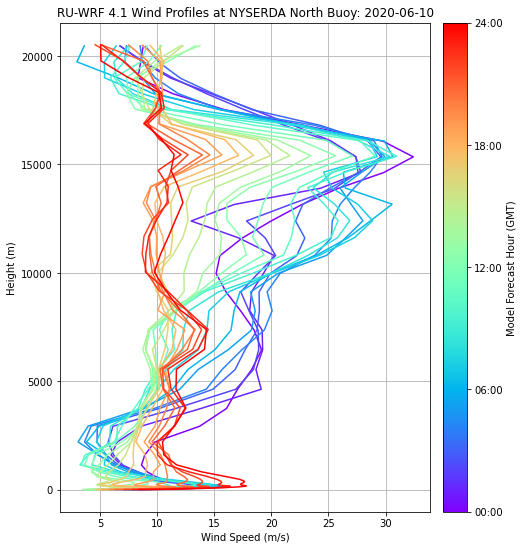

In [11]:
# set up plot
fig, ax = plt.subplots(figsize=(8, 9))
plt.subplots_adjust(right=0.88, left=0.15)
plt.grid()

# loop through each timestamp and plot each profile
for idx, t in enumerate(tm.values):
    # grab the data at the specified location/index for each timestamp
    height = ds.height_agl.sel(time=t)[:, i, j]
    u = ds.u.sel(time=t)[:, i, j]
    v = ds.v.sel(time=t)[:, i, j]

    # calculate wind speed (m/s) from u and v
    ws = np.sqrt(np.square(u) + np.square(v))

    # plot the wind speed data for the timestamp
    ax.plot(ws, height, c=colors[idx])

    # after plotting the last profile, add the colorbar and labels to the plot
    if idx == (len(tm) - 1):
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='rainbow'),
                            ax=ax, orientation='vertical', fraction=0.09, 
                            pad=0.03, label='Model Forecast Hour (GMT)')
        cbar.set_ticks([0, .25, .5, .75, 1])
        cbar.ax.set_yticklabels(cbar_labs)
        ax.set_xlabel('Wind Speed (m/s)')
        ax.set_ylabel('Height (m)')
        ax.set_title(ttl)
        
        # save the plot to your local machine
        print('save filepath: {}'.format(sfig))
        plt.savefig(sfig, dpi=200)

This plot depicts profiles of wind speeds for each model hour and height for a 24 hour period. Let's subset the data for heights less than 1200m and create another plot for the lower region of the atmosphere. In order to do this, let's explore how to find the indices where height < 1200 and use that to subset the windspeed data.

In [12]:
# print all of the model heights at the buoy location
height = ds.height_agl.sel(time=tm[0])[:, i, j]
height

<xarray.DataArray 'height_agl' (bottom_top: 47)>
array([8.471013e+00, 2.543110e+01, 4.241302e+01, 5.940770e+01, 7.642884e+01,
       9.349496e+01, 1.106235e+02, 1.278354e+02, 1.451571e+02, 1.626327e+02,
       1.803741e+02, 1.986070e+02, 2.177330e+02, 2.384845e+02, 2.622052e+02,
       2.913092e+02, 3.300631e+02, 3.858789e+02, 4.712547e+02, 6.059451e+02,
       8.177763e+02, 1.139123e+03, 1.596566e+03, 2.197723e+03, 2.925922e+03,
       3.747743e+03, 4.626417e+03, 5.532138e+03, 6.445262e+03, 7.353243e+03,
       8.246536e+03, 9.118778e+03, 9.967596e+03, 1.079268e+04, 1.159494e+04,
       1.237650e+04, 1.313983e+04, 1.388744e+04, 1.462273e+04, 1.534970e+04,
       1.607319e+04, 1.679944e+04, 1.752972e+04, 1.826161e+04, 1.899443e+04,
       1.972842e+04, 2.046962e+04], dtype=float32)
Coordinates:
    XLONG       float32 -72.72241
    XLAT        float32 39.960476
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46
    time        datetime64[ns] 2020-06-10
   

In [13]:
# find the indices where height is <1200m
height_ind = np.where(height < 1200)
height_ind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),)

In [14]:
# use that index to subset the height data array
height = ds.height_agl.sel(time=tm[0])[:, i, j][height_ind]
height

<xarray.DataArray 'height_agl' (bottom_top: 22)>
array([   8.471013,   25.431099,   42.413017,   59.407703,   76.42884 ,
         93.494965,  110.62346 ,  127.83539 ,  145.15707 ,  162.63266 ,
        180.37411 ,  198.60701 ,  217.73296 ,  238.48447 ,  262.20517 ,
        291.30917 ,  330.06314 ,  385.8789  ,  471.2547  ,  605.94507 ,
        817.7763  , 1139.1226  ], dtype=float32)
Coordinates:
    XLONG       float32 -72.72241
    XLAT        float32 39.960476
  * bottom_top  (bottom_top) int32 0 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20 21
    time        datetime64[ns] 2020-06-10
    time_run    datetime64[ns] ...
Attributes:
    units:          m
    long_name:      Model Height for Mass Grid (AGL)
    _FillValue:     nan
    description:    model height - [AGL] (mass grid)
    standard_name:  height
    comment:        Model height above ground level
    axis:           Z
    positive:       up
    _ChunkSizes:    [  1  24 162 162]

Since the model heights can change with each hour, we will have to create the index for each timestamp and subset the data with that specific index.

save filepath: /Users/lgarzio/Documents/rucool/tutorials/WRF_wsprofiles_20200610_subset.png


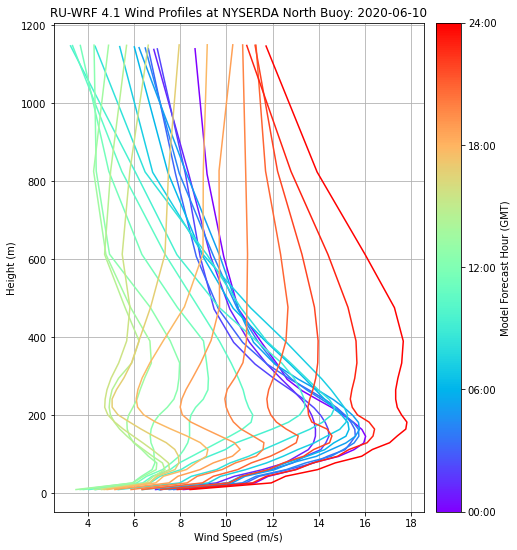

In [15]:
# create a new save file path
figname = 'WRF_wsprofiles_{}_subset.png'.format(plt_date.strftime('%Y%m%d'))
sfig = os.path.join(save_dir, figname)

# set up plot
fig, ax = plt.subplots(figsize=(8, 9))
plt.subplots_adjust(right=0.88, left=0.15)
plt.grid()

for idx, t in enumerate(tm.values):
    # grab the data at the specified location/index for each timestamp
    height = ds.height_agl.sel(time=t)[:, i, j]
    u = ds.u.sel(time=t)[:, i, j]
    v = ds.v.sel(time=t)[:, i, j]
    
    # create the height index <1200m
    height_ind = np.where(height < 1200)
    
    # calculate wind speed (m/s) from u and v
    ws = np.sqrt(np.square(u) + np.square(v))

    # plot the wind speed data for the timestamp, using the height index to select
    # only the data <1200m
    ax.plot(ws[height_ind], height[height_ind], c=colors[idx])

    # after plotting the last profile, add the colorbar and labels to the plot
    if idx == (len(tm) - 1):
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='rainbow'),
                            ax=ax, orientation='vertical', fraction=0.09, 
                            pad=0.03, label='Model Forecast Hour (GMT)')
        cbar.set_ticks([0, .25, .5, .75, 1])
        cbar.ax.set_yticklabels(cbar_labs)
        ax.set_xlabel('Wind Speed (m/s)')
        ax.set_ylabel('Height (m)')
        ax.set_title(ttl)
        
        # save the plot to your local machine
        print('save filepath: {}'.format(sfig))
        plt.savefig(sfig, dpi=200)